In [91]:
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from a345_utilities import print_header, mem_usage     
from matplotlib.patches import Rectangle as rect 
import numpy as np
import os, time
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture
from a345_utilities import print_header 
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.coordinates import SkyCoord
from photutils import CircularAnnulus
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting
from astropy.time import Time
import re
import warnings
warnings.filterwarnings('ignore')
from astropy.stats import sigma_clipped_stats

import pandas as pd


from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError

# ast = AstrometryNet()
# ast.API_URL = 'http://nova.astro.gla.ac.uk/api' # local server
# ast.api_key = 'XXXXXXXX'
# ast.URL = 'http://nova.astro.gla.ac.uk'

#API access of the remote server
ast = AstrometryNet()
ast.API_URL = 'http://nova.astrometry.net/api' # local server
ast.URL = 'http://nova.astrometry.net'
#API key for Giles Hammond
ast.api_key = 'cyilczrjxdbmnhum'

In [133]:
def plot(juliandate: np.ndarray, magnitude: np.ndarray, mag_err: np.ndarray = None):
    plt.figure(figsize=(10, 5))
    plt.scatter(juliandate, magnitude )
    plt.errorbar(juliandate, magnitude, yerr=mag_err, fmt='o')
    plt.xlabel('Time (JD)')
    plt.ylabel('Magnitude')
    plt.title('Light Curve')
    plt.show()
def plot_lc(file: str):
    data = pd.read_csv('W_UMa_G.txt')
    jd = data['JD']
    mag = data['Magnitude']
    try:
        mag_err = data['Mag_err']
        
    except:
        mag_err = None
    plot(jd, mag, mag_err)


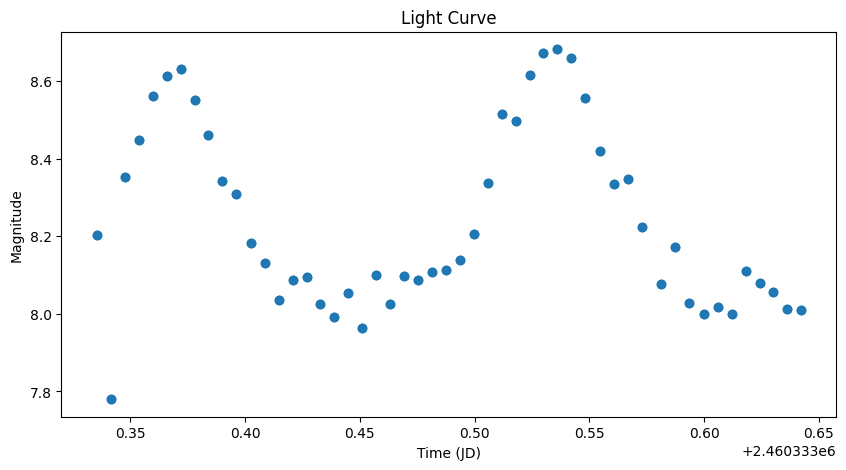

In [134]:
plot_lc('W_UMa_G.txt')

In [92]:
path_cal = '/Volumes/external_2T/calibration/2023-10/neg10c/master'
path_data =  '/Volumes/external_2T'
target_jd = []
target_mags = []

RADIUS = 19
def light_curve(star:str,band:str,exposure:str, radius: int = RADIUS) -> None:
    
    '''
    Function to calibrate raw .fits files, plate solve and extract magnitudes \n
    Star is a string \n
    Band is the colour band \n 
    Exposure is the exposure time in seconds (time with s)
    '''
    
    data_cal = np.transpose(np.loadtxt(path_data + '/'+ 'cal_stars/' + star + '_calibration_stars.txt', skiprows=1, delimiter=","))
    id_cal=data_cal[0]
    mag_g_cal=data_cal[3]
    mag_g_err = data_cal[4]
    mag_i_cal=data_cal[7]
    mag_i_err = data_cal[8]
    mag_r_cal=data_cal[5]
    mag_r_err = data_cal[6]
    ra_cal=data_cal[1]
    dec_cal=data_cal[2]
    
    
    
    counter = 0
    with fits.open(path_cal+'/dark_flat_gr_3s_master.fits') as hdu:
        flatdark_data = hdu[0].data
    
    with fits.open(path_cal+'/dark_'+exposure+'_master.fits') as hdu:
        dark_data = hdu[0].data

    if re.search('G',band):
        mag_cal1 = mag_g_cal
        mag_err = mag_g_err
        with fits.open(path_cal+'/flat_g_master.fits') as hdu:
            flat = hdu[0].data      
    
    if re.search('I',band):
        mag_cal1 = mag_i_cal
        mag_err = mag_i_err
        
        with fits.open(path_cal+'/flat_i_master.fits') as hdu:
            flat = hdu[0].data 
    
    if re.search('R',band):
        mag_cal1 = mag_r_cal
        mag_err = mag_r_err
        
        with fits.open(path_cal+'/flat_r_master.fits') as hdu:
            flat = hdu[0].data 
    
    star_list = os.listdir(path_data+'/'+star+'/'+band)       

    for img in star_list:
        print(img)

            
        if img.endswith('.fits'):          
            with fits.open(path_data+'/'+star+'/'+band+'/'+img) as hdu:
                img_header = hdu[0].header
                img_data = hdu[0].data
            if re.search('_E_',img):
                img_data = np.rot90(img_data, k=2)

            img_c = (img_data-dark_data)*(np.mean(flat-flatdark_data))/(flat-flatdark_data)
            mean, median, std = sigma_clipped_stats(img_c)
            daofind = DAOStarFinder(fwhm=4, threshold=3.5*std)  
            sources = daofind(img_c)

            for col in sources.colnames:  
                sources[col].info.format = '%.8g'
            sources.sort('flux')
            sources.reverse()
            if counter == 0:
                print(len(sources))
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++PLATE SOLVING++++++++++++++++++++++++++++++++++++++++++++++++++++
            try:
                wcs_header = None 
                wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                                        img_c.shape[1], 
                                                        img_c.shape[0],
                                                        #scale_est =  0.724,
                                                        #scale_units = 'arcsecperpix',
                                                        solve_timeout=300)
                if wcs_header:
                    print('Success')
                else:
                    print('Failed') 
                
                img_header.update(wcs_header)
                if counter == 0:
                    
                    print(img_header['OBJCTDEC'],img_header['OBJCTRA'])
                hdu = fits.PrimaryHDU()
                hdu.header.update(img_header)       
                hdu.data = img_c
                # hdu.writeto(filename+'corrected'+img, overwrite=True)
                wcs = WCS(img_header)
            
            
            except TimeoutError:       
                print('\n -> ##FAIL: Timeout while solving, try a longer timeout, optmise number of sources (200-800 seems about right)')
                wcs = WCS(img_header)
            # with fits.open(filename+'corrected'+img) as hdu:
            #     reloaded_header = hdu[0].header
            #     reloaded_data   = hdu[0].data
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++PLATE SOLVING++++++++++++++++++++++++++++++++++++++++++++++++++++
            # number of sources from DAO Starfinder to plot
            N_source=20
            # number of calibration stars to plot




            # plot yellow circles around the sources found by DAO starfinder
            positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
            apertures_define = CircularAperture(positions_dao, r=25)
            apertures_dao=apertures_define[0:N_source+1]
            # apertures_dao.plot(color='yellow', lw=1, alpha=1)

            r1=radius
            r2=r1+2
            r3=r2+4

            # plot blue circles around the calibration stars from VizieR
            source1_x, source1_y= wcs.wcs_world2pix(ra_cal,dec_cal,1)
            source1 = np.transpose((source1_x, source1_y))
            source1_aperture = CircularAperture(source1, r1)  
            source1_annulus = CircularAnnulus(source1, r2, r3)

            source1_phot = [source1_aperture, source1_annulus]
            # source1_aperture.plot(color='blue', lw=2, alpha=1)
            # source1_annulus.plot(color='deepskyblue', lw=2, alpha=1)


            source2_x, source2_y =(sources['xcentroid'] , sources['ycentroid'] )

            Coor_x, Coor_y = wcs.wcs_pix2world(source2_x, source2_y, 1) 
            source2=np.transpose((source2_x, source2_y))
            source2_aperture = CircularAperture(source2, r1)  
            # source2_aperture.plot(color='red', lw=2, alpha=1)

            source2 = np.transpose((source2_x, source2_y))
            source2_aperture = CircularAperture(source2, r1)  
            source2_annulus = CircularAnnulus(source2, r2, r3)

            source2_phot = [source2_aperture, source2_annulus]
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++APERTURE PHOTOMETRY+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

            phot_table_source1 = aperture_photometry(img_c, source1_phot)
            phot_table_source2 = aperture_photometry(img_c, source2_phot)

            for col in phot_table_source1.colnames:
                phot_table_source1[col].info.format = '%.8g'  # for consistent table output

            bkg_mean_cal1 = float(phot_table_source1[0]['aperture_sum_1'] / source1_annulus.area)
            bcal1 = bkg_mean_cal1 * source1_aperture.area

            cal1_flux=float(phot_table_source1[0]['aperture_sum_0'] - bcal1)


            for col in phot_table_source2.colnames:
                phot_table_source2[col].info.format = '%.8g'  # for consistent table output

            bkg_mean_targ = float(phot_table_source2[0]['aperture_sum_1'] / source2_annulus.area)

            targcal = bkg_mean_targ * source2_aperture.area

            r = np.linspace(1, 30, 30)
            test_r2 = r+2
            test_r3 = r+4
            if counter == 0:
                flux = []
                plt.figure()
                for i in np.arange(1,31,1):
                    
                    source2 = np.transpose((source2_x, source2_y))
                    source2_aperture = CircularAperture(source2, i)  
                    source2_annulus = CircularAnnulus(source2, test_r2[i-1], test_r3[i-1])

                    source2_phot = [source2_aperture, source2_annulus]
                    phot_table_source2 = aperture_photometry(img_c, source2_phot)

                    bkg_mean_targ = float(phot_table_source2[0]['aperture_sum_1'] / source2_annulus.area)

                    targcal = bkg_mean_targ * source2_aperture.area
                    targ_flux=float(phot_table_source2[0]['aperture_sum_0'] - targcal)
                    flux.append(targ_flux)
                    
                plt.plot(r,flux)
                plt.show()
            
            targ_flux=float(phot_table_source2[0]['aperture_sum_0'] - targcal)
            mag_targ=mag_cal1[0] + 2.5*np.log10(cal1_flux/targ_flux)

            t_fits=img_header['DATE-OBS']
            t = Time(t_fits, format='isot', scale='utc')
            t_jd=t.jd 
            target_mags.append(mag_targ)
            target_jd.append(t_jd)
            print(mag_targ)
            counter +=1
    

In [93]:
light_curve('W UMa','Chr G','10s',10)

W-UMa_LIGHT_2024-01-23T20-55-56Z_Chr-G_10s_-10.0C_W_0007.fits
417
Solving..

KeyboardInterrupt: 

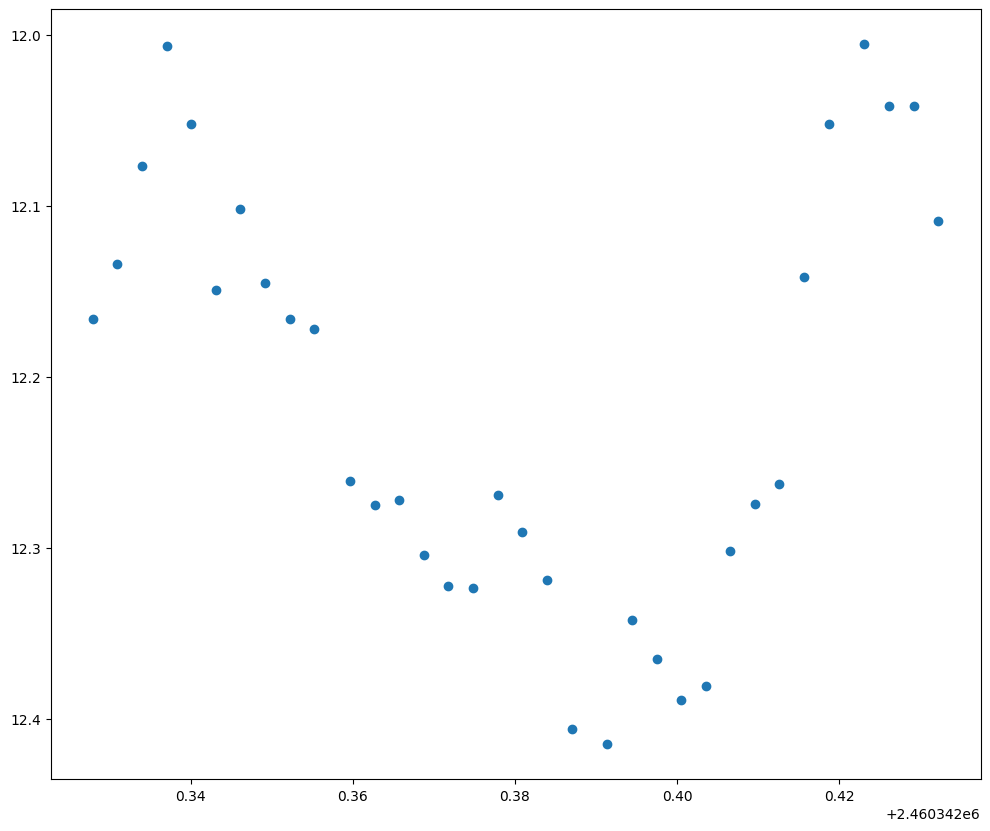

In [55]:
gem_r = np.transpose(np.array([target_jd,target_mags]))

np.savetxt('NSVS7293918_R.txt',gem_r,delimiter=',',header='JD,Magnitude')


In [7]:


RADIUS = 19
def error_func(star:str,band:str,exposure:str, radius: int = RADIUS) -> None:
    
    '''

    '''
    
    data_cal = np.transpose(np.loadtxt(path_data + '/'+ 'cal_stars/' + star + '_calibration_stars.txt', skiprows=1, delimiter=","))
    mag_g_cal=data_cal[3]
    mag_g_err = data_cal[4]
    mag_i_cal=data_cal[7]
    mag_i_err = data_cal[8]
    mag_r_cal=data_cal[5]
    mag_r_err = data_cal[6]
    ra_cal=data_cal[1]
    dec_cal=data_cal[2]
    
    
    
    counter = 0
    with fits.open(path_cal+'/dark_flat_gr_3s_master.fits') as hdu:
        flatdark_data = hdu[0].data
    
    with fits.open(path_cal+'/dark_'+exposure+'_master.fits') as hdu:
        dark_data = hdu[0].data

    if re.search('G',band):
        mag_cal1 = mag_g_cal
        mag_err = mag_g_err
        with fits.open(path_cal+'/flat_g_master.fits') as hdu:
            flat = hdu[0].data      
    
    if re.search('I',band):
        mag_cal1 = mag_i_cal
        mag_err = mag_i_err
        
        with fits.open(path_cal+'/flat_i_master.fits') as hdu:
            flat = hdu[0].data 
    
    if re.search('R',band):
        mag_cal1 = mag_r_cal
        mag_err = mag_r_err
        
        with fits.open(path_cal+'/flat_r_master.fits') as hdu:
            flat = hdu[0].data 
    
    star_list = os.listdir(path_data+'/'+star+'/'+band)       

    for img in star_list:
        print(img)

            
        if img.endswith('.fits'):          
            with fits.open(path_data+'/'+star+'/'+band+'/'+img) as hdu:
                img_header = hdu[0].header
                img_data = hdu[0].data
            if re.search('_E_',img):
                img_data = np.rot90(img_data, k=2)

            img_c = (img_data-dark_data)*(np.mean(flat-flatdark_data))/(flat-flatdark_data)
            mean, median, std = sigma_clipped_stats(img_c)
            daofind = DAOStarFinder(fwhm=4, threshold=4*std)  
            sources = daofind(img_c)

            for col in sources.colnames:  
                sources[col].info.format = '%.8g'
            sources.sort('flux')
            sources.reverse()
            if counter == 0:
                print(len(sources))
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++PLATE SOLVING++++++++++++++++++++++++++++++++++++++++++++++++++++
            # try:
            #     wcs_header = None 
            #     wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
            #                                             img_c.shape[1], 
            #                                             img_c.shape[0],
            #                                             #scale_est =  0.724,
            #                                             #scale_units = 'arcsecperpix',
            #                                             solve_timeout=300)
            #     if wcs_header:
            #         print('Success')
            #     else:
            #         print('Failed') 
                
            #     img_header.update(wcs_header)
            #     if counter == 0:
                    
            #         print(img_header['OBJCTDEC'],img_header['OBJCTRA'])
            #     hdu = fits.PrimaryHDU()
            #     hdu.header.update(img_header)       
            #     hdu.data = img_c
            #     # hdu.writeto(filename+'corrected'+img, overwrite=True)
            #     wcs = WCS(img_header)
            
            
            # except TimeoutError:       
            #     print('\n -> ##FAIL: Timeout while solving, try a longer timeout, optmise number of sources (200-800 seems about right)')
            #     wcs = WCS(img_header)
            # with fits.open(filename+'corrected'+img) as hdu:
            #     reloaded_header = hdu[0].header
            #     reloaded_data   = hdu[0].data
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++PLATE SOLVING++++++++++++++++++++++++++++++++++++++++++++++++++++
            # number of sources from DAO Starfinder to plot
            N_source=20
            # number of calibration stars to plot




            # plot yellow circles around the sources found by DAO starfinder
            positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
            apertures_define = CircularAperture(positions_dao, r=25)
            apertures_dao=apertures_define[0:N_source+1]
            # apertures_dao.plot(color='yellow', lw=1, alpha=1)

            r1=radius
            r2=r1+2
            r3=r2+4

            # plot blue circles around the calibration stars from VizieR
            source1_x, source1_y= wcs.wcs_world2pix(ra_cal,dec_cal,1)
            source1 = np.transpose((source1_x, source1_y))
            source1_aperture = CircularAperture(source1, r1)  
            source1_annulus = CircularAnnulus(source1, r2, r3)

            source1_phot = [source1_aperture, source1_annulus]
            # source1_aperture.plot(color='blue', lw=2, alpha=1)
            # source1_annulus.plot(color='deepskyblue', lw=2, alpha=1)


            source2_x, source2_y =(sources['xcentroid'] , sources['ycentroid'] )

            Coor_x, Coor_y = wcs.wcs_pix2world(source2_x, source2_y, 1) 
            source2=np.transpose((source2_x, source2_y))
            source2_aperture = CircularAperture(source2, r1)  
            # source2_aperture.plot(color='red', lw=2, alpha=1)

            source2 = np.transpose((source2_x, source2_y))
            source2_aperture = CircularAperture(source2, r1)  
            source2_annulus = CircularAnnulus(source2, r2, r3)

            source2_phot = [source2_aperture, source2_annulus]
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++APERTURE PHOTOMETRY+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

            phot_table_source1 = aperture_photometry(img_c, source1_phot)
            phot_table_source2 = aperture_photometry(img_c, source2_phot)

            for col in phot_table_source1.colnames:
                phot_table_source1[col].info.format = '%.8g'  # for consistent table output

            bkg_mean_cal1 = float(phot_table_source1[0]['aperture_sum_1'] / source1_annulus.area)
            bcal1 = bkg_mean_cal1 * source1_aperture.area

            cal1_flux=float(phot_table_source1[0]['aperture_sum_0'] - bcal1)


            for col in phot_table_source2.colnames:
                phot_table_source2[col].info.format = '%.8g'  # for consistent table output

            bkg_mean_targ = float(phot_table_source2[0]['aperture_sum_1'] / source2_annulus.area)

            targcal = bkg_mean_targ * source2_aperture.area

            r = np.linspace(1, 30, 30)
            test_r2 = r+2
            test_r3 = r+4
            if counter == 0:
                flux = []
                plt.figure()
                for i in np.arange(1,31,1):
                    
                    source2 = np.transpose((source2_x, source2_y))
                    source2_aperture = CircularAperture(source2, i)  
                    source2_annulus = CircularAnnulus(source2, test_r2[i-1], test_r3[i-1])

                    source2_phot = [source2_aperture, source2_annulus]
                    phot_table_source2 = aperture_photometry(img_c, source2_phot)

                    bkg_mean_targ = float(phot_table_source2[0]['aperture_sum_1'] / source2_annulus.area)

                    targcal = bkg_mean_targ * source2_aperture.area
                    targ_flux=float(phot_table_source2[0]['aperture_sum_0'] - targcal)
                    flux.append(targ_flux)
                    
                plt.plot(r,flux)
                plt.show()
            
            targ_flux=float(phot_table_source2[0]['aperture_sum_0'] - targcal)
            mag_targ=mag_cal1[0] + 2.5*np.log10(cal1_flux/targ_flux)

            t_fits=img_header['DATE-OBS']
            t = Time(t_fits, format='isot', scale='utc')
            t_jd=t.jd 
            
            sigma = (())
            
            
            
            
            
            target_mags.append(mag_targ)
            target_jd.append(t_jd)
            print(mag_targ)
            counter +=1
    

In [8]:
error_func('V403 Gem','Chr G','180s',11)

V403-Gem_LIGHT_2024-02-02T22-23-37Z_Chr-G_180s_-10.0C_E_0025.fits
746


NameError: name 'wcs' is not defined